# 1. Introduction + Set Up

Transfer learning in computer vision is the process of using a pre-trained model on a new dataset of images. This is extremely useful when the dataset is not that big. ML models thrive when there is a lot of data available to train on, but it many scenarios, obtaining large datasets is quite difficult. The pre-trained model is trained on a big dataset, and the weights are preserved. The trained layers of the model is used as the basis for our new model. We will be using the VGG16 model to predict whether or not a lesion is a malignant or benign tumor.

Additionally, training models take up a lot of time, and so we will utilize the TPU accelerator to reduce it time it takes to train our model.

Run the following cell to import the necessary packages. Don't forget to change the accelerator to TPU v3-8 on the right.

In [1]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import partial
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import train_test_split
import tempfile
import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Device: grpc://10.0.0.2:8470
Number of replicas: 8
2.2.0


Running the following cell will save time in loading the data as it allows for parallel processing. TPU can only work with Google Cloud files and cannot be run with local files. We want to state a relatively bigger batch size, as our data is inbalanced. We will go over what inbalanced data is in later cells.


In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path()
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [1024, 1024]
IMAGE_RESIZE = [256, 256]

# 2. Load the data

Now we will load in our data. For this notebook, we will be importing the TFRecord Files. It is good practice to divide the training set data into two. The smaller dataset will be the validation set. Having a validation set is useful to prevent overfitting as the finetuning of the model will be done by calculating metrics on the validation set and not the training set.

```train_test_split``` will divide our dataset for us. For reproducible results, ```random_state``` 5 was arbitrarily chosen.

In [3]:
TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(
    tf.io.gfile.glob(GCS_PATH + '/tfrecords/train*.tfrec'),
    test_size=0.1, random_state=5
)
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/test*.tfrec')
print('Train TFRecord Files:', len(TRAINING_FILENAMES))
print('Validation TFRecord Files:', len(VALID_FILENAMES))
print('Test TFRecord Files:', len(TEST_FILENAMES))

Train TFRecord Files: 14
Validation TFRecord Files: 2
Test TFRecord Files: 16


## 2.1 Decoding the data

The images have to be converted to tensors so that it will be a valid input in our model. As images utilize an RBG scale, we specify 3 channels.

It is also best practice to normalize data before it is is fed into the model. For our image data, we will scale it down so that the value of each pixel will range from [0, 1] instead of [0. 255].

We also reshape our data so that all of the images will be the same shape. Although the TFRecord files have already been reshaped for us, it is best practice to reshape the input so that we know exactly what's going in to our model.

In [4]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

As we load in our data, we need both our ```X``` and our ```Y```. The X is our image; the model will find features and patterns in our image dataset. We want to predict Y, the probability that the lesion in the image is malignant. When we input our training dataset into the model, it is necessary know what the labels of our images are. For our testing set, we do not need to feed in the labels because the model will predict it for us. In this particular dataset, our label is the ```target``` feature. We will to through our TFRecords and parse out the image and the target values.

In [5]:
def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

Our dataset is not ordered in any meaningful way, so the order can be ignored when loading our dataset. By ignoring the order and reading files as soon as they come in, it will take a shorter time to load the data.

In [6]:
def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

## 2.2 Data augmentation

Image augmentation introduces new images into our data, and generally prevents the model from overfitting and leads to higher accuracy on testing datasets. For this particular dataset, we will randomly flip the image horizontally.

In [7]:
def augmentation_pipeline(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, IMAGE_RESIZE)
    return image, label

## 2.3 Define loading methods

We define the following three functions to get our three different datasets.

In [8]:
def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(augmentation_pipeline, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [9]:
def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALID_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [10]:
def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

The following cell returns the number of images we have in each dataset.

In [11]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

Run the following cell to visualize how many images we have in each of our datasets. Notice that the training dataset has the most images. This is normal, as having more training points will allow the model to learn more.

In [12]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print(
    'Dataset: {} training images, {} validation images, {} unlabeled test images'.format(
        NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES
    )
)

Dataset: 28984 training images, 4142 validation images, 10982 unlabeled test images


# 3. Building our model

Now that our data has been loaded, we will now start building our model.

## 3.1 Define the learning rate

The following function allows for the model to change the learning rate as it runs each epoch. Having a learning rate that is too high will prevent our model from converging. However, having a learning rate that is too small will cause our model to run for far too long. With this function, the model will know how to change its learning rate after each epoch and update the learning rate itself to allow for increased efficiency while still allowing the model to converge.

In [13]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

## 3.2 Explore our data

Before we build our model, we want to look at the data to see what we are working with. When we look at our training and validation dataset, we see that our data is inbalanced. So what does inbalanced data mean?

Our data is inbalanced because when we look at our data, we see that only 1.76% of the images are images of malignant lesions while 98.24% of the images are benign. This means that there are not enough images of malignant lesions that our model can learn from.

In [14]:
train_csv = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
test_csv = pd.read_csv('../input/siim-isic-melanoma-classification/test.csv')

In [15]:
total_img = train_csv['target'].size

malignant = np.count_nonzero(train_csv['target'])
benign = total_img - malignant

print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total_img, malignant, 100 * malignant / total_img))

Examples:
    Total: 33126
    Positive: 584 (1.76% of total)



In [16]:
train_dataset = get_training_dataset()
valid_dataset = get_validation_dataset()

In [17]:
image_batch, label_batch = next(iter(train_dataset))

In [18]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("MALIGNANT")
        else:
            plt.title("BENIGN")
        plt.axis("off")

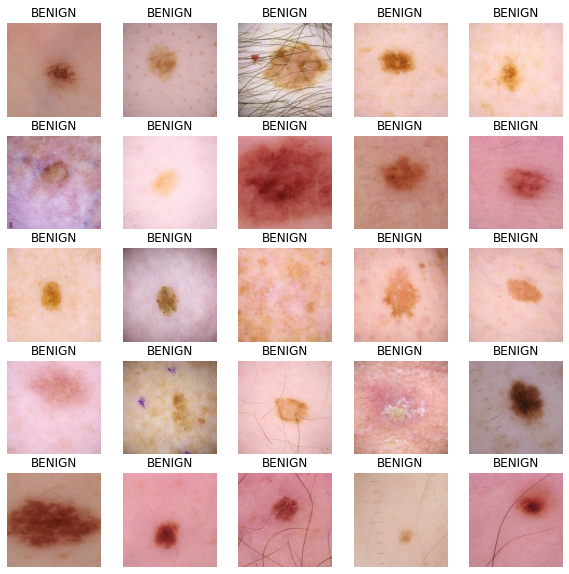

In [19]:
show_batch(image_batch.numpy(), label_batch.numpy())

## 3.3 Build our base model

Transfer learning is a great way to reap the benefits of a well-trained model without having the train the model ourselves. For this notebook, we want to import the VGG16 model. As this model has already been trained, we do not want to change the weights in this model and must set its ```trainable``` attribute to ```False```. We also don't want to include the top layers because the classification that we want to accomplish in this model is not the same as the classification that the model was originally trained on. We want the a single node outputed that determines the probability thatthe lesion will be malignant. However, because the data is inbalanced, this model will not work very well.

In [20]:
def make_model(output_bias = None, metrics = None):    
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    base_model = tf.keras.applications.Xception(input_shape=(*IMAGE_RESIZE, 3),
                                                include_top=False,
                                                weights='imagenet')
    
    base_model.trainable = False
    
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid',
                              bias_initializer=output_bias)
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=metrics)
    
    return model

In [21]:
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

## 3.4 Correcting for data inbalance

### 3.4.1 Set initial bias

We want to set the correct initial bias for our model so that it will not waste time figuring out that there are not many malignant images in our dataset. We want our output layer to reflect the inbalance that we have in our data.

In [22]:
initial_bias = np.log([malignant/benign])
initial_bias

array([-4.02038586])

### 3.4.2 Set class weights

Since there are not enough malignant images, we want these malignant images to have more weight in our model. By increasing the weight of these malignant images, the model will pay more attention to them, and this will help balance out the difference in quantity.

In [23]:
weight_for_0 = (1 / benign)*(total_img)/2.0 
weight_for_1 = (1 / malignant)*(total_img)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.51
Weight for class 1: 28.36


## 3.5 Deciding our evaluation metrics

When we compile our model, we do not want our metric to be ```accuracy```. If we run the model, with an ```accuracy``` metric, it will give us false confidence in our model. If we look at the dataset, we see that 98% of the images are classifed as benign, ```0```. Now, if accuracy was the sole determinant of our model, a model that always outputs 0 will achieve a high accuracy although the model is not good. Additionally, for the type of prediction we are making, it is riskier to predict a malignant tumor as benign than it is to predict a benign tumor as malignant. Thus, our metric should not be just accuracy. The competition scores the model by finding the area under the ROC curve, which is why our metric will be set to ```keras.metrics.AUC```.

In [24]:
with strategy.scope():
    model = make_model(output_bias = initial_bias, metrics=tf.keras.metrics.AUC(name='auc'))

83689472/83683744 [==============================] - 0s 0us/step


We can use callbacks to stop training when there are no improvements in our validation set predictions, and this stops overfitting. Additionally, we can save the best weights for our model so that it doesn't have to be retrained. At the end of the training process, the model will restore the weights of its best iteration.

In [25]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("melanoma_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [26]:
history = model.fit(
    train_dataset, epochs=100,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_dataset,
    validation_steps=VALID_STEPS,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    class_weight=class_weight
)

Epoch 1/100
226/226 [==============================] - 72s 319ms/step - loss: 0.6084 - auc: 0.7699 - val_loss: 0.3363 - val_auc: 0.7408 - lr: 0.0100
Epoch 2/100
226/226 [==============================] - 45s 198ms/step - loss: 0.4998 - auc: 0.8383 - val_loss: 0.2864 - val_auc: 0.7296 - lr: 0.0089
Epoch 3/100
226/226 [==============================] - 41s 183ms/step - loss: 0.4673 - auc: 0.8639 - val_loss: 0.1685 - val_auc: 0.7607 - lr: 0.0079
Epoch 4/100
226/226 [==============================] - 37s 165ms/step - loss: 0.4385 - auc: 0.8799 - val_loss: 0.1951 - val_auc: 0.7731 - lr: 0.0071
Epoch 5/100
226/226 [==============================] - 46s 202ms/step - loss: 0.4039 - auc: 0.8977 - val_loss: 0.1495 - val_auc: 0.7735 - lr: 0.0063
Epoch 6/100
226/226 [==============================] - 42s 187ms/step - loss: 0.3847 - auc: 0.9067 - val_loss: 0.1136 - val_auc: 0.7663 - lr: 0.0056
Epoch 7/100
226/226 [==============================] - 35s 153ms/step - loss: 0.3774 - auc: 0.9126 - val_l

# 4. Predicting results

Using our model, let us predict the probability that a tumor is malignant based on the image of the lesion using our testing dataset.

In [27]:
test_ds = get_test_dataset(ordered=True)

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)

Computing predictions...


Let's visualize how our predictions look like. We want our submission file to look like the sample submission file, so let's visualize how that looks.

In [28]:
sub = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')
sub.head()

,image_name,target
0,ISIC_0052060,0
1,ISIC_0052349,0
2,ISIC_0058510,0
3,ISIC_0073313,0
4,ISIC_0073502,0


Let's create our submission file.

In [29]:
print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

Generating submission.csv file...


In [30]:
pred_df = pd.DataFrame({'image_name': test_ids, 'target': np.concatenate(probabilities)})
pred_df.head()

,image_name,target
0,ISIC_6381819,0.017053
1,ISIC_5583376,0.017053
2,ISIC_6408546,0.035544
3,ISIC_6932354,0.036311
4,ISIC_8191278,0.017053


In [31]:
del sub['target']
sub = sub.merge(pred_df, on='image_name')
sub.to_csv('submission.csv', index=False)
sub.head()

,image_name,target
0,ISIC_0052060,0.017053
1,ISIC_0052349,0.019425
2,ISIC_0058510,0.017053
3,ISIC_0073313,0.017053
4,ISIC_0073502,0.017053
